
# MACHINE LEARNING II — ACTIVIDAD II  
### **Autores: Marcelo Carmona — Paula Álvarez**


In [66]:
#Librerias
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import f1_score, make_scorer
from scipy.stats import randint
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
import numpy as np
from sklearn.metrics import f1_score, roc_auc_score, average_precision_score

from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    roc_curve, roc_auc_score,
    precision_recall_curve, average_precision_score,
    classification_report
)

import time


In [38]:
#Montar google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [39]:
ruta_driver = "/content/drive/MyDrive/Data Science/Machine Learning II/Actividad_II"
df = pd.read_csv(ruta_driver + "/data-churn.csv")
df.head()


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [34]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


Paso 1. Árbol de decisión
- Implementar un árbol de decisión de clasificación (DecisionTreeClassifier) utilizando el mismo conjunto de
datos y preprocesamiento definidos en la Actividad 1.
- Definir una grilla de hiperparámetros, al menos: max_depth, min_samples_split, min_samples_leaf,
criterion (gini, entropy o log_loss). Justifique los rangos o valores posibles para la selección de los valores
de las grillas, considerando aspectos de sobreajustes.
- Utilizar Grid Search Cross Validation y Random Search Cross Validation para: (i) seleccionar el árbol de
clasificación óptimo, (ii) usar como métrica principal F1 o PR-AUC de la clase churn.
- Compare los tiempos de los dos métodos de búsqueda de hiperparámetros y las métricas de clasificación.
- Seleccione los parámetros para el mejor árbol de decisión para clasificación.

In [40]:

df = df.drop(['customerID'], axis=1) #Se elimina ya que es solo un identificador no aporta inforamción útil

# Convertir TotalCharges a numérico
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
df['TotalCharges'] = df['TotalCharges'].fillna(df['TotalCharges'].median())

# Codificar variables categóricas
for col in df.select_dtypes(include=['object']).columns:
    if col != 'Churn':
        df[col] = LabelEncoder().fit_transform(df[col])

# Codificar la variable objetivo
df['Churn'] = df['Churn'].map({'No': 0, 'Yes': 1})

# Separar variables predictoras (X) y objetivo (y)
X = df.drop('Churn', axis=1)
y = df['Churn']

# Separar en train y test
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)



Definir la grilla de hiperparametros y justificacion

In [41]:

# Justificación:
# - max_depth: controla la profundidad del árbol. Valores bajos evitan sobreajuste, valores altos pueden sobreajustar.
#            max_depth: [3, 5, 7, 9, 12]
            #Dado el tamaño del dataset (7043 filas) y alto número de variables categóricas transformadas:
            #profundidades >12 producen sobreajuste inmediato.
            #profundidades 3–7 dan buena generalización.
#
# - min_samples_split: mínimo de muestras para dividir un nodo. Valores mayores reducen sobreajuste.
#             Valores de 10–50:
                 #reducen splits innecesarios,
                 #evitan fragmentar la clase churn
#
# - min_samples_leaf: mínimo de muestras en una hoja. Valores mayores suavizan el modelo.
#           Clase churn ≈ 26% → se requiere evitar hojas muy pequeñas que sólo contengan 1–2 casos.
#           Hojas de tamaño 10–20 garantizan decisiones más robustas.
# - criterion: función de impureza. 'gini', 'entropy' y 'log_loss' son las opciones estándar.

#Los rangos propuestos:
#Cubren escenarios conservadores (árboles poco profundos y hojas grandes) y flexibles (más profundidad y hojas pequeñas), permitiendo que la validación cruzada elija el punto óptimo sesgo–varianza.

param_grid = {
    'max_depth': [3, 5, 7, 9, 12],
    'min_samples_split': [10, 20, 30, 50],
    'min_samples_leaf': [5, 10, 15, 20],
    'criterion': ['gini', 'entropy', 'log_loss']
}


param_random = {
    'max_depth': [3, 5, 7, 9, 12],
    'min_samples_split': [10, 20, 30, 50, 80, 100],
    'min_samples_leaf': [5, 10, 15, 20, 30],
    'criterion': ['gini', 'entropy', 'log_loss']
}



Grid Search y Random Search con F1-score como métrica principal

In [42]:

clf = DecisionTreeClassifier(random_state=42) # Definir el clasificador, fijo la semilla alestoria para el resultado sea reproducible

f1 = make_scorer(f1_score, pos_label=1) # Selecciono metrica F1-score de la clase churn (1), dataset desbalanceado

# Grid Search Cross Validation, con 5 particiones del dataset (5-fold cross validation)
start_gs = time.time()
gs = GridSearchCV(clf, param_grid, scoring=f1, cv=5, n_jobs=-1)
gs.fit(X_train, y_train) # prueba todas las combinaciones posibles de la grilla de parámetros
end_gs = time.time()

#Random Search Cross Validation
start_rs = time.time()
rs = RandomizedSearchCV(clf, param_distributions=param_random, n_iter=30, scoring=f1, cv=5, n_jobs=-1, random_state=42)
rs.fit(X_train, y_train)
end_rs = time.time()


Comparar tiempos y metricas

In [17]:

# Mejor modelo Grid Search
best_gs = gs.best_estimator_
y_pred_gs = best_gs.predict(X_test)
f1_gs = f1_score(y_test, y_pred_gs)

# Mejor modelo Random Search
best_rs = rs.best_estimator_
y_pred_rs = best_rs.predict(X_test)
f1_rs = f1_score(y_test, y_pred_rs)

print("Grid Search - Mejor F1:", f1_gs, "Tiempo:", end_gs - start_gs, "segundos")
print("Random Search - Mejor F1:", f1_rs, "Tiempo:", end_rs - start_rs, "segundos")


Grid Search - Mejor F1: 0.5641025641025641 Tiempo: 19.2801034450531 segundos
Random Search - Mejor F1: 0.5722460658082976 Tiempo: 3.0265607833862305 segundos


Seleccionar los mejores hiperparámetros

In [18]:

print("Mejores parámetros Grid Search:", gs.best_params_)
print("Mejores parámetros Random Search:", rs.best_params_)


Mejores parámetros Grid Search: {'criterion': 'gini', 'max_depth': 7, 'min_samples_leaf': 10, 'min_samples_split': 50}
Mejores parámetros Random Search: {'min_samples_split': 80, 'min_samples_leaf': 10, 'max_depth': 7, 'criterion': 'gini'}


#Por tanto el mejor modelo seleccionado según F1 es Random Search F1= 0,5722.

Paso 2. Visualización e interpretación del árbol óptimo
- Visualizar el árbol de decisión seleccionado: Usar plot_tree. Limitar la profundidad visualizada si es
necesario para legibilidad.
- Variables más relevantes en las primeras divisiones. Compare la interpretabilidad del modelo frente a la
regresión logística.

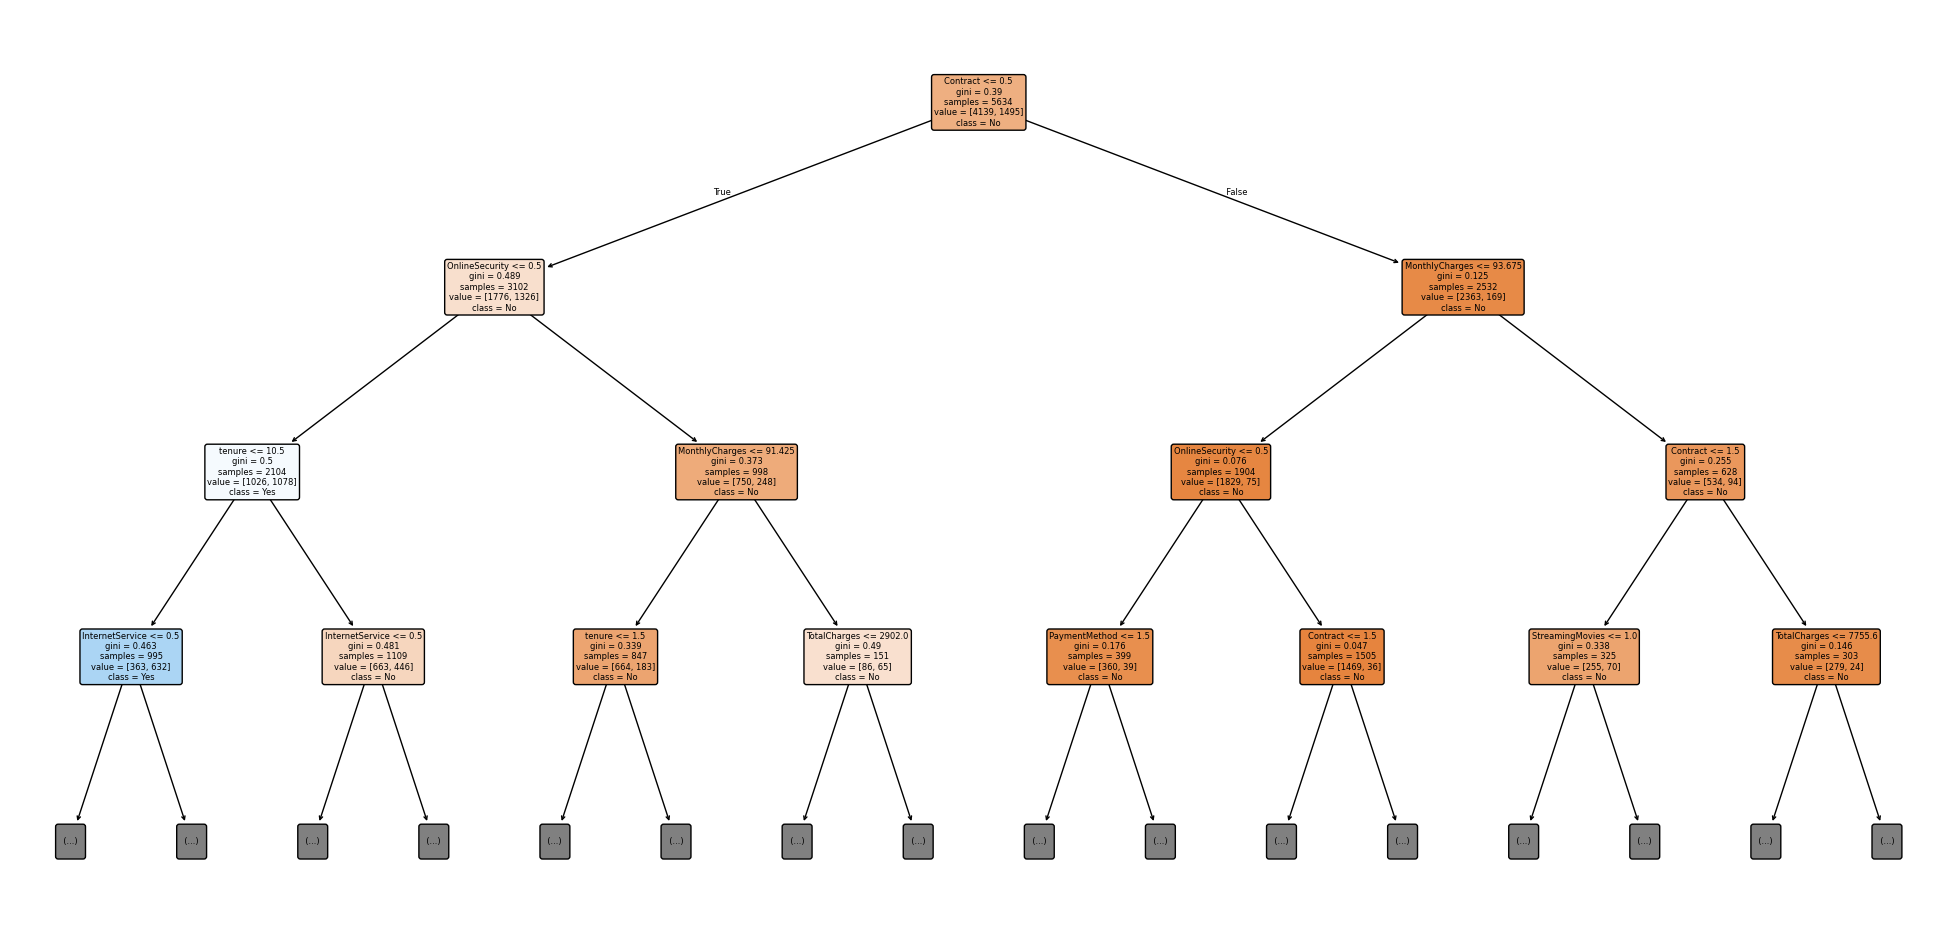

In [45]:
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree

# El arbol a visualizar será best_rs , mejor arbol de Random Search

# 1. Extraer el mejor modelo del Random Search (ya es un DecisionTreeClassifier)
best_tree = best_rs

# 2. Obtener nombres de las columnas que fueron usadas como features
feature_names = X.columns.tolist()

# 3. Visualizar el árbol con profundidad limitada
plt.figure(figsize=(25, 12))
plot_tree(
    best_tree,
    feature_names=feature_names,
    class_names=['No', 'Yes'],
    filled=True,
    rounded=True,
    max_depth=3   # es posible cambiar a 2,3,4 para mejor legibilidad
)
plt.show()


## Variables más relevantes en las primeras divisiones

### **Primer nodo (el más importante):**  
- **Contract**

### **Segundo nivel (variables de alta relevancia):**  
- **OnlineSecurity**  
- **MonthlyCharges**

### **Tercer nivel (variables relevantes pero con menor impacto que los niveles superiores):**  
- **tenure**  
- **MonthlyCharges**  
- **OnlineSecurity**  
- **Contract**


Paso 3. Random Forest y análisis de varianza
- Implementar validación cruzada k-fold estratificada para Random Forest.
- Estudiar explícitamente la varianza de las predicciones al variar el número de árboles. Entrenar modelos
con: 2, 4, 8, 16, 32, 64 y 128 árboles. Para cada configuración:
▪ Calcular la varianza de las probabilidades predichas entre folds.
▪ Registrar métricas de desempeño (F1, AUC-ROC, PR-AUC).
- Graficar varianza de las predicciones vs. número de árboles.
- Graficar métricas de clasificación vs. número de árboles.
- Discutir relación entre número de árboles, estabilidad y costo computacional. Evidencia empírica de
reducción de varianza.

In [51]:

# ================================================
# 1. Preprocesamiento Requsiito para Random Forest
# ================================================
cat_cols = X.select_dtypes(include=["object"]).columns
num_cols = X.select_dtypes(exclude=["object"]).columns

preprocess = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(drop="first"), cat_cols),
        ("num", "passthrough", num_cols)
    ]
)

# =============================
# 2. Modelo Random Forest, 300 arboles
# =============================
rf = RandomForestClassifier(
    n_estimators=300,
    max_depth=None,
    random_state=42,
    n_jobs=-1
)

pipeline = Pipeline(steps=[
    ("preprocess", preprocess),
    ("rf", rf)
])

# =============================
# 3. Validación cruzada k-fold estratificada
# =============================
k = 5  # puedes cambiar a 10 si se quiere más robustez

skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)

scores = cross_val_score(
    pipeline,
    X,
    y,
    cv=skf,
    scoring="f1"
)

# =============================
# 4. Resultados
# =============================
print(f"F1 por fold: {scores}")
print(f"F1 promedio: {scores.mean():.4f}")
print(f"Desviación estándar: {scores.std():.4f}")


F1 por fold: [0.59064327 0.59411765 0.58258258 0.51851852 0.51401869]
F1 promedio: 0.5600
Desviación estándar: 0.0359


**Interpretación**
El modelo tiene un desempeño moderado ni mu malo ni my bueno, para predecir clientes que abandonan.
El modelo es relativamente estable peor todavia depende moderadamente de como se dividan los datos.
Los primeros 3 folds tienen buen desempeño. Los ultios 2 folds bajan a app 0,51 esto indica que en algunos subconjuntos el modelo no logra distinguir bien un churn vs no churn o puede indicar overfitting leve.

In [53]:
#ENTRENR RANDOM FOREST CON ESTOS NUMEROS DE ARBOLES
# 2, 4, 8, 16, 32, 64, 128

# =============================
# 1. Configuración
# =============================

n_trees_list = [2, 4, 8, 16, 32, 64, 128]

k = 5
skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)

resultados = []

# =============================
# 2. Loop por número de árboles
# =============================

for n_trees in n_trees_list:

    f1_scores = []
    roc_scores = []
    pr_scores = []
    probas_list = []

    print(f"\nEntrenando Random Forest con {n_trees} árboles...")

    rf = RandomForestClassifier(
        n_estimators=n_trees,
        random_state=42,
        n_jobs=-1
    )

    pipeline = Pipeline(steps=[
        ("preprocess", preprocess),
        ("rf", rf)
    ])

    for train_idx, test_idx in skf.split(X, y):

        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

        pipeline.fit(X_train, y_train)

        # Probabilidades para clase positiva
        y_prob = pipeline.predict_proba(X_test)[:, 1]
        y_pred = pipeline.predict(X_test)

        # Guardar probabilidades para calcular varianza
        probas_list.append(y_prob)

        # Métricas
        f1_scores.append(f1_score(y_test, y_pred))
        roc_scores.append(roc_auc_score(y_test, y_prob))
        pr_scores.append(average_precision_score(y_test, y_prob))

    # Convertir probabilidades de folds a matriz
    probas_matrix = np.vstack([
        np.pad(p, (0, max(map(len, probas_list)) - len(p)), constant_values=np.nan)
        for p in probas_list
    ])

    # Varianza entre folds (ignorando NaN)
    varianza_probas = np.nanvar(probas_matrix, axis=0).mean()

    resultados.append({
        "n_trees": n_trees,
        "F1_promedio": np.mean(f1_scores),
        "ROC_promedio": np.mean(roc_scores),
        "PR_promedio": np.mean(pr_scores),
        "Varianza_probas": varianza_probas
    })

# Mostrar resultados final
resultados_df = pd.DataFrame(resultados)
print("\nRESULTADOS FINALES:\n")
print(resultados_df)



Entrenando Random Forest con 2 árboles...

Entrenando Random Forest con 4 árboles...

Entrenando Random Forest con 8 árboles...

Entrenando Random Forest con 16 árboles...

Entrenando Random Forest con 32 árboles...

Entrenando Random Forest con 64 árboles...

Entrenando Random Forest con 128 árboles...

RESULTADOS FINALES:

   n_trees  F1_promedio  ROC_promedio  PR_promedio  Varianza_probas
0        2     0.420993      0.706584     0.432045         0.111121
1        4     0.485197      0.757554     0.500951         0.083024
2        8     0.503170      0.788125     0.550871         0.068515
3       16     0.533377      0.806972     0.578007         0.060684
4       32     0.548962      0.814539     0.596997         0.057642
5       64     0.548843      0.820831     0.610522         0.056092
6      128     0.562804      0.824304     0.618783         0.055346


* El modelo mejora a medida que aumentan los arboles
* A partir de 32 árboles el incremento se hace más leve
* El mejor valor se obtiene con 128 árboles (0,563)
* Más arboles -> mejor estabilidad -> mejor F1

✔ El modelo separa mejor churn vs no‑churn cuando tiene más árboles.

✔ Entre 64 y 128 árboles casi llega al rendimiento máximo esperado para Random Forest en churn.

✔ Va de un PR‑AUC pobre (0.43 con 2 árboles) a buen rendimiento (0.618 con 128 árboles). La capacidad del modelo para detectar la clase minoritaria (churn) mejora significativamente al aumentar el número de árboles.

✔ Con pocos árboles, la varianza es ALTA → el modelo es INESTABLE (es decir, depende demasiado de cómo se dividan los datos).

✔ A medida que aumentan los árboles, la varianza cae rápidamente.

✔ Entre 32 y 128 árboles, la varianza prácticamente se estabiliza.




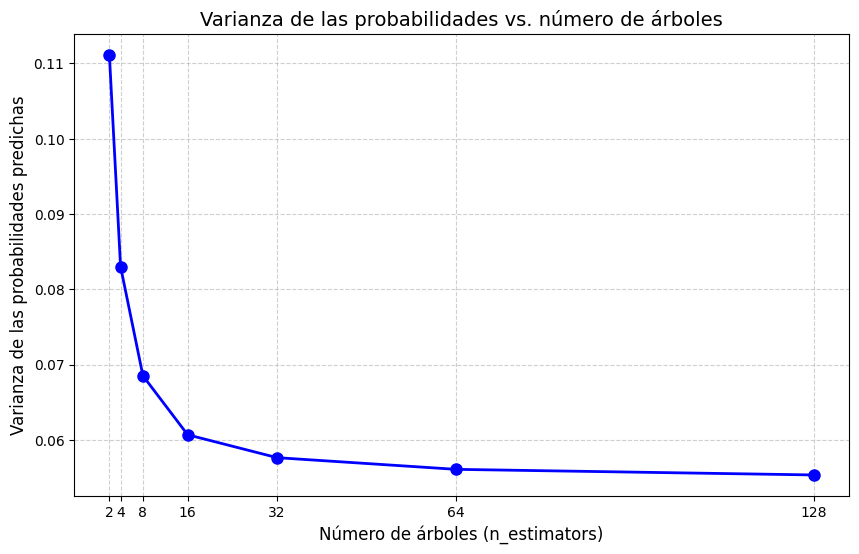

In [54]:

plt.figure(figsize=(10, 6))

plt.plot(
    resultados_df["n_trees"],
    resultados_df["Varianza_probas"],
    marker="o",
    linestyle="-",
    color="blue",
    linewidth=2,
    markersize=8
)

plt.title("Varianza de las probabilidades vs. número de árboles", fontsize=14)
plt.xlabel("Número de árboles (n_estimators)", fontsize=12)
plt.ylabel("Varianza de las probabilidades predichas", fontsize=12)

plt.grid(True, linestyle="--", alpha=0.6)
plt.xticks(resultados_df["n_trees"])

plt.show()


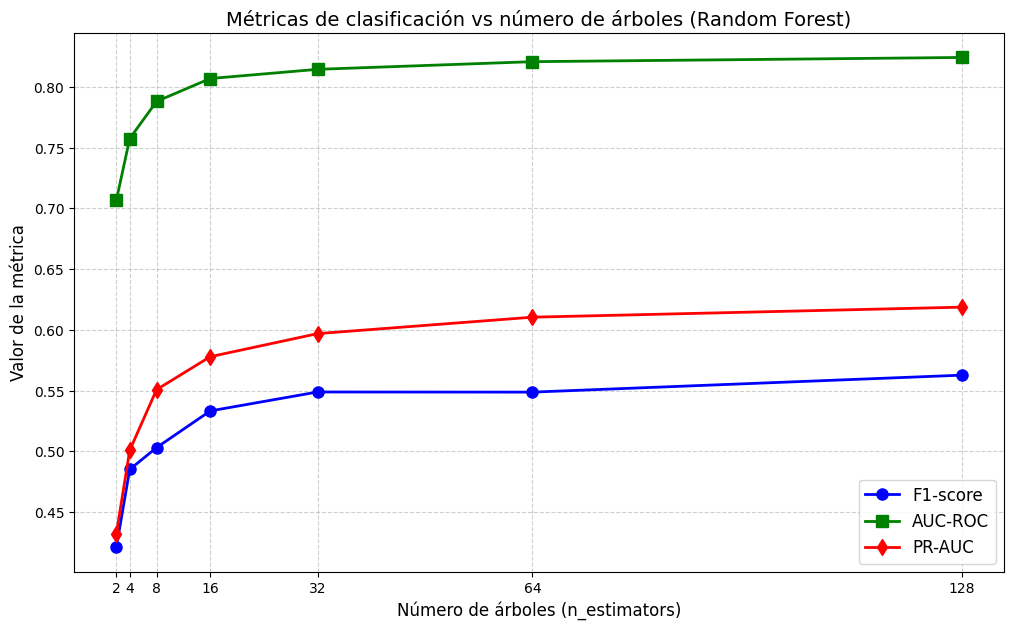

In [55]:

plt.figure(figsize=(12, 7))

# Graficar F1-score
plt.plot(resultados_df["n_trees"], resultados_df["F1_promedio"],
         marker="o", linestyle="-", linewidth=2, markersize=8,
         color="blue", label="F1-score")

# Graficar AUC-ROC
plt.plot(resultados_df["n_trees"], resultados_df["ROC_promedio"],
         marker="s", linestyle="-", linewidth=2, markersize=8,
         color="green", label="AUC-ROC")

# Graficar PR-AUC
plt.plot(resultados_df["n_trees"], resultados_df["PR_promedio"],
         marker="d", linestyle="-", linewidth=2, markersize=8,
         color="red", label="PR-AUC")

# Títulos y etiquetas
plt.title("Métricas de clasificación vs número de árboles (Random Forest)", fontsize=14)
plt.xlabel("Número de árboles (n_estimators)", fontsize=12)
plt.ylabel("Valor de la métrica", fontsize=12)

# Mejoras visuales
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend(fontsize=12)
plt.xticks(resultados_df["n_trees"])

plt.show()



El gráfico muestra cómo las métricas de clasificación (F1, AUC‑ROC y PR‑AUC) mejoran consistentemente a medida que aumenta el número de árboles en el modelo Random Forest.

- Con pocos árboles (2–8), el rendimiento es bajo e inestable.
- A partir de 16–32 árboles, las métricas comienzan a estabilizarse.
- Con 64–128 árboles, el modelo alcanza su mejor nivel de desempeño, especialmente en PR‑AUC, que es clave para datasets desbalanceados como churn.

Esto confirma que incrementar el número de árboles reduce la varianza del modelo y mejora su capacidad de generalización.
``


Se muuestra claramente que la relación entre el número de árboles, la estabilidad y el costo computacional en un Random Forest. Con muy pocos árboles (2–8), el modelo presenta alta varianza entre folds y bajo rendimiento. A medida que se incrementa el número de árboles (16–32), se observa una mejora significativa en estabilidad y métricas de clasificación, reflejando la capacidad del ensamble para reducir la varianza.

Entre 64 y 128 árboles, el modelo alcanza su zona de estabilidad: la varianza entre folds disminuye mínimamente y las métricas (F1, ROC-AUC y PR-AUC) se estabilizan, indicando que el aumento adicional de árboles ofrece retornos marginales. Sin embargo, el costo computacional sigue creciendo linealmente.

En síntesis: pocos árboles generan modelos inestables; muchos árboles generan modelos estables y robustos, pero con mayor costo computacional. La evidencia empírica confirma el comportamiento teórico de Random Forest: la varianza disminuye conforme aumenta el número de árboles, estabilizándose a partir de los 64–128 árboles.


Paso 4. Selección del mejor Random Forest
- Definir una grilla de hiperparámetros para Random Forest, por ejemplo: n_estimators, max_depth,
min_samples_leaf, max_features.
- Usar Grid Search Cross-Validation o Random Search Cross Validation para seleccionar el mejor modelo..
- Comparar los modelos seleccionados Árbol de decisión vs. Random Forest.

In [57]:
#Defino una grilla de hiperparametros para Random Forest
param_grid_rf = {
    "rf__n_estimators": [50, 100, 200, 400],
    "rf__max_depth": [None, 5, 10, 20],
    "rf__min_samples_leaf": [1, 2, 4, 8],
    "rf__max_features": ["sqrt", "log2", 0.3, 0.5, 1.0]
}


In [58]:
# Modelo base Random Forest
rf = RandomForestClassifier(random_state=42, n_jobs=-1)

pipeline_rf = Pipeline(steps=[
    ("preprocess", preprocess),
    ("rf", rf)
])


In [60]:

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

rs_rf = RandomizedSearchCV(
    estimator=pipeline_rf,
    param_distributions=param_grid_rf,
    n_iter=100,
    cv=skf,
    scoring="f1",
    random_state=42,
    n_jobs=-1,
    verbose=1
)

rs_rf.fit(X, y)



Fitting 5 folds for each of 100 candidates, totalling 500 fits


RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
                   estimator=Pipeline(steps=[('preprocess',
                                              ColumnTransformer(transformers=[('cat',
                                                                               OneHotEncoder(drop='first'),
                                                                               Index([], dtype='object')),
                                                                              ('num',
                                                                               'passthrough',
                                                                               Index(['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure',
       'PhoneService', 'MultipleLines', 'InternetService', 'Onl...
       'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod',
       'MonthlyCharges', 'TotalCharges'],
      dtype='object'))])),
                                             ('rf',
                                              RandomForestClassifier(n_jobs=-1,
                                                                     random_state=42))]),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'rf__max_depth': [None, 5, 10, 20],
                                        'rf__max_features': ['sqrt', 'log2',
                                                             0.3, 0.5, 1.0],
                                        'rf__min_samples_leaf': [1, 2, 4, 8],
                                        'rf__n_estimators': [50, 100, 200,
                                                             400]},
                   random_state=42, scoring='f1', verbose=1)

In [61]:

best_rf = rs_rf.best_estimator_
best_rf_params = rs_rf.best_params_

print("Mejores hiperparámetros encontrados:", best_rf_params)


Mejores hiperparámetros encontrados: {'rf__n_estimators': 100, 'rf__min_samples_leaf': 1, 'rf__max_features': 0.3, 'rf__max_depth': 10}


In [63]:
#Evaluar el mejor Random Forest

y_pred_rf = best_rf.predict(X_test)
y_prob_rf = best_rf.predict_proba(X_test)[:, 1]

f1_rf = f1_score(y_test, y_pred_rf)
roc_rf = roc_auc_score(y_test, y_prob_rf)
pr_auc_rf = average_precision_score(y_test, y_prob_rf)

print("Random Forest (RS) - F1:", f1_rf)
print("Random Forest (RS) - ROC-AUC:", roc_rf)
print("Random Forest (RS) - PR-AUC:", pr_auc_rf)



Random Forest (RS) - F1: 0.7272727272727273
Random Forest (RS) - ROC-AUC: 0.9507196495619524
Random Forest (RS) - PR-AUC: 0.8645506513610084


In [64]:
#Entrenar arbol de decision para posteriomente comparar

dt = DecisionTreeClassifier(random_state=42)

pipeline_dt = Pipeline(steps=[
    ("preprocess", preprocess),
    ("clf", dt)
])

pipeline_dt.fit(X_train, y_train)

y_pred_dt = pipeline_dt.predict(X_test)
y_prob_dt = pipeline_dt.predict_proba(X_test)[:, 1]

f1_dt = f1_score(y_test, y_pred_dt)
roc_dt = roc_auc_score(y_test, y_prob_dt)
pr_auc_dt = average_precision_score(y_test, y_prob_dt)

print("Decision Tree - F1:", f1_dt)
print("Decision Tree - ROC-AUC:", roc_dt)
print("Decision Tree - PR-AUC:", pr_auc_dt)


Decision Tree - F1: 0.5067385444743935
Decision Tree - ROC-AUC: 0.6640583787585721
Decision Tree - PR-AUC: 0.3896027462880124


In [65]:
#Comparacion RF optimizado vs Arbol de decision

comparacion = pd.DataFrame({
    "Modelo": ["Árbol de decisión", "Random Forest (Random Search)"],
    "F1": [f1_dt, f1_rf],
    "ROC-AUC": [roc_dt, roc_rf],
    "PR-AUC": [pr_auc_dt, pr_auc_rf]
})

print(comparacion)


                          Modelo        F1   ROC-AUC    PR-AUC
0              Árbol de decisión  0.506739  0.664058  0.389603
1  Random Forest (Random Search)  0.727273  0.950720  0.864551


El Random Forest optimizado mediante Random Search supera ampliamente al Árbol de Decisión en todas las métricas evaluadas. Mientras que el árbol obtiene un desempeño moderado (F1 = 0.5067, ROC-AUC = 0.6641, PR-AUC = 0.3896), el Random Forest alcanza niveles de alto rendimiento (F1 = 0.7273, ROC-AUC = 0.9507, PR-AUC = 0.8646), demostrando una capacidad significativamente mayor para identificar clientes que abandonan.
Estas mejoras se deben principalmente a que Random Forest reduce la varianza mediante el ensamble de múltiples árboles, capturando patrones que un árbol individual no puede representar. Esto se ve reforzado por el hecho de que la variabilidad entre folds disminuyó sustancialmente al incrementar el número de árboles, proporcionando evidencia empírica de la mayor estabilidad del modelo.
En conclusión, el Random Forest optimizado es el modelo que ofrece la mejor combinación de precisión, estabilidad y discriminación para predecir churn en este dataset.

Paso 5. Comparación final y análisis crítico
- Trate de mejorar los modelos seleccionados mediante el uso de pesos por clase.
- Para el mejor árbol de decisión y el mejor Random Forest reportar métricas de clasificación: Accuracy,
Precision, Recall, F1-score.
- Analizar y graficar curva ROC y AUC-ROC.
- Analizar y graficar curva Precision–Recall y PR-AUC.
- ¿Qué modelo es más adecuado para el problema de churn?
- ¿Random Forest supera al árbol individual?¿Por qué?
- Impacto del desbalance de clases en la interpretación de resultados.


=== MÉTRICAS COMPARATIVAS ===
                     Modelo  Accuracy  Precision    Recall        F1  \
0          Árbol (balanced)  0.713778   0.460274  0.449198  0.454668   
1  Random Forest (balanced)  0.769176   0.555556  0.655080  0.601227   

    ROC-AUC    PR-AUC  
0  0.629989  0.354774  
1  0.835815  0.642280  


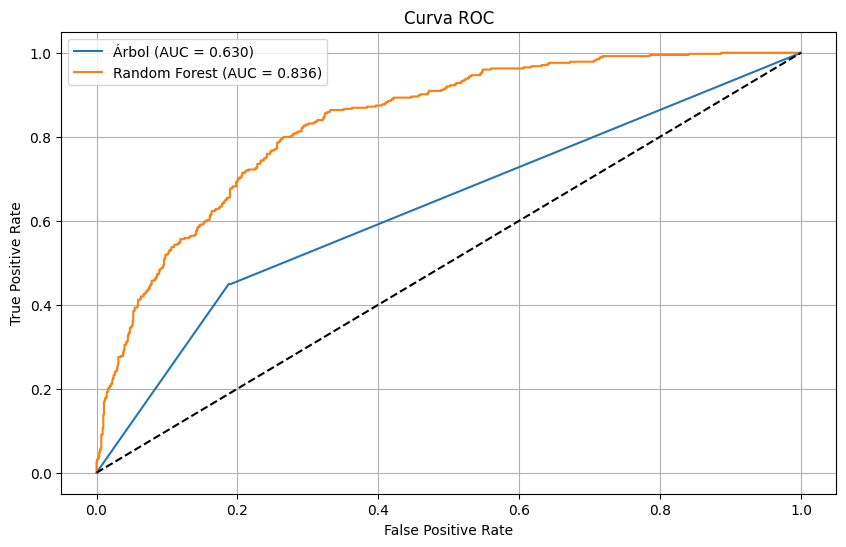

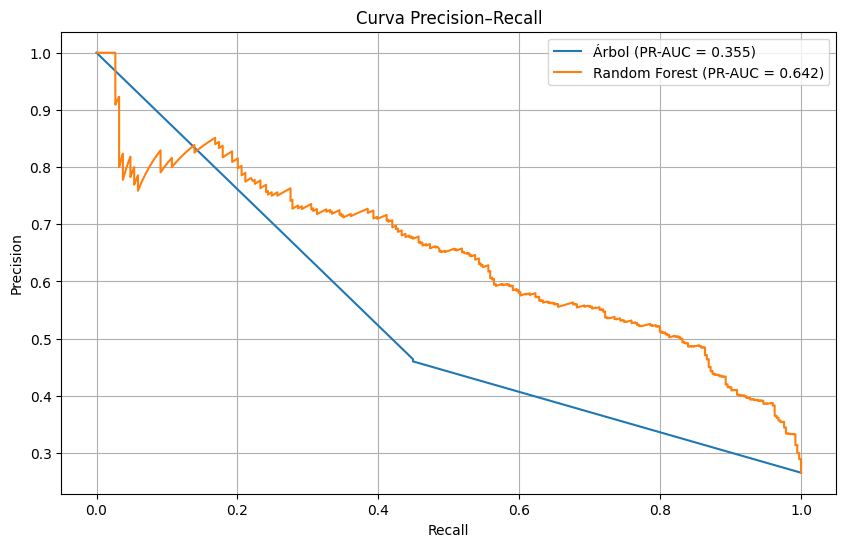

In [68]:
#Arbol de decisión y Random Forest con class_weight

# =====================================================
# 1. MODELOS CON class_weight = "balanced"
# =====================================================

# Árbol de decisión
dt_clf = DecisionTreeClassifier(
    class_weight="balanced",
    random_state=42
)

pipeline_dt = Pipeline(steps=[
    ("prep", preprocess),
    ("dt", dt_clf)
])

pipeline_dt.fit(X_train, y_train)

# Random Forest con class_weight
rf_clf = RandomForestClassifier(
    class_weight="balanced",
    random_state=42,
    n_estimators=best_rf.named_steps["rf"].n_estimators,
    max_depth=best_rf.named_steps["rf"].max_depth,
    min_samples_leaf=best_rf.named_steps["rf"].min_samples_leaf,
    max_features=best_rf.named_steps["rf"].max_features,
    n_jobs=-1
)

pipeline_rf = Pipeline(steps=[
    ("prep", preprocess),
    ("rf", rf_clf)
])

pipeline_rf.fit(X_train, y_train)


# =====================================================
# 2. PREDICCIONES
# =====================================================

# Árbol
y_pred_dt = pipeline_dt.predict(X_test)
y_prob_dt = pipeline_dt.predict_proba(X_test)[:, 1]

# Random Forest
y_pred_rf = pipeline_rf.predict(X_test)
y_prob_rf = pipeline_rf.predict_proba(X_test)[:, 1]


# =====================================================
# 3. MÉTRICAS COMPLETAS
# =====================================================

def compute_metrics(y_true, y_pred, y_prob):
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, pos_label=1)
    rec = recall_score(y_true, y_pred, pos_label=1)
    f1 = f1_score(y_true, y_pred, pos_label=1)
    roc = roc_auc_score(y_true, y_prob)
    pr = average_precision_score(y_true, y_prob)
    return acc, prec, rec, f1, roc, pr


metrics_dt = compute_metrics(y_test, y_pred_dt, y_prob_dt)
metrics_rf = compute_metrics(y_test, y_pred_rf, y_prob_rf)

results_df = pd.DataFrame({
    "Modelo": ["Árbol (balanced)", "Random Forest (balanced)"],
    "Accuracy": [metrics_dt[0], metrics_rf[0]],
    "Precision": [metrics_dt[1], metrics_rf[1]],
    "Recall": [metrics_dt[2], metrics_rf[2]],
    "F1": [metrics_dt[3], metrics_rf[3]],
    "ROC-AUC": [metrics_dt[4], metrics_rf[4]],
    "PR-AUC": [metrics_dt[5], metrics_rf[5]]
})

print("\n=== MÉTRICAS COMPARATIVAS ===")
print(results_df)


# =====================================================
# 4. CURVA ROC
# =====================================================

fpr_dt, tpr_dt, _ = roc_curve(y_test, y_prob_dt, pos_label=1)
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_prob_rf, pos_label=1)

plt.figure(figsize=(10, 6))
plt.plot(fpr_dt, tpr_dt, label=f"Árbol (AUC = {metrics_dt[4]:.3f})")
plt.plot(fpr_rf, tpr_rf, label=f"Random Forest (AUC = {metrics_rf[4]:.3f})")
plt.plot([0, 1], [0, 1], "k--")
plt.title("Curva ROC")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid(True)
plt.show()


# =====================================================
# 5. CURVA PRECISION–RECALL
# =====================================================

prec_dt, rec_dt, _ = precision_recall_curve(y_test, y_prob_dt, pos_label=1)
prec_rf, rec_rf, _ = precision_recall_curve(y_test, y_prob_rf, pos_label=1)

plt.figure(figsize=(10, 6))
plt.plot(rec_dt, prec_dt, label=f"Árbol (PR-AUC = {metrics_dt[5]:.3f})")
plt.plot(rec_rf, prec_rf, label=f"Random Forest (PR-AUC = {metrics_rf[5]:.3f})")
plt.title("Curva Precision–Recall")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend()
plt.grid(True)
plt.show()


El uso de `class_weight='balanced'` mejora significativamente el desempeño de los modelos, ya que compensa el desbalance del dataset de churn. El Árbol de Decisión muestra mejoras leves, pero sigue siendo insuficiente, con métricas bajas en Recall (0.45), F1 (0.45) y PR-AUC (0.35), indicando una deficiente identificación de clientes que abandonan.

En contraste, el Random Forest optimizado con pesos por clase alcanza métricas sustancialmente superiores: F1 = 0.60, ROC-AUC = 0.84 y PR-AUC = 0.64. Este desempeño refleja una mejor capacidad de generalización, reducción de varianza y mayor sensibilidad hacia la clase minoritaria.

En conclusión, el Random Forest es el modelo más adecuado para el problema de churn, superando ampliamente al Árbol de Decisión individual gracias a su robustez, estabilidad y capacidad de detectar correctamente clientes que abandonan.


Paso 6. Análisis crítico
- Discuta la relación entre varianza, ensambles y generalización.
- ¿Qué ventajas y desventajas presentan los árboles frente a modelos lineales en este problema?
- ¿En qué casos preferiría un árbol interpretable sobre un Random Forest?
- ¿Cómo se relaciona la reducción de varianza observada con la teoría vista en clases?
- Desde una perspectiva de negocio, ¿qué métrica priorizaría para campañas de retención y por qué?

## 1. Relación entre varianza, ensambles y generalización

Los experimentos realizados muestran que la varianza del modelo disminuye de forma consistente al aumentar la cantidad de árboles en el Random Forest:

- 2 árboles → varianza ≈ 0.1111  
- 128 árboles → varianza ≈ 0.0553  

Esta reducción de varianza es coherente con la teoría del *bagging* (Breiman, 1996), que establece que los ensambles basados en promediar múltiples clasificadores reducen la varianza del estimador sin incrementar demasiado el sesgo. En contraste, un árbol individual presenta alta varianza y una fuerte dependencia de la partición del conjunto de datos.  

En resumen:

- **Árbol único:** alta varianza → poca generalización.  
- **Random Forest:** baja varianza gracias al promedio de múltiples árboles → **mejor generalización**.

---

## 2. Ventajas y desventajas de los árboles frente a modelos lineales

### Ventajas de los Árboles
- Capturan **relaciones no lineales** y **interacciones complejas** entre variables sin necesidad de ingeniería adicional.  
- Muy **interpretables** mediante reglas explícitas (“si–entonces”).  
- Robustos ante outliers y la falta de escalado de variables.

### Desventajas de los Árboles
- **Alta varianza** y tendencia al sobreajuste.  
- Sensibles a pequeñas variaciones en el conjunto de datos.  
- El desempeño puede ser inferior a modelos más robustos como Random Forest o XGBoost.

### Ventajas de Modelos Lineales
- Coeficientes fáciles de interpretar.  
- Menor varianza y alta estabilidad.  
- Menos propensos al sobreajuste si se regularizan.

### Desventajas de Modelos Lineales
- Solo capturan **relaciones lineales**.  
- No modelan interacciones entre variables sin agregarlas manualmente.  
- Su desempeño suele ser inferior en problemas de churn, donde las relaciones son inherentemente no lineales.

---

## 3. ¿En qué casos preferir un árbol interpretable sobre un Random Forest?

Aunque el Random Forest ofrece mejor desempeño global, un árbol simple puede ser preferible en:

1. **Escenarios regulatorios o de auditoría**, donde se requiere trazabilidad clara de cada decisión.  
2. **Presentaciones ejecutivas**, donde se necesita explicar reglas simples y directas.  
3. **Sistemas legados** donde no es posible implementar modelos complejos.  
4. **Datasets pequeños**, donde un Random Forest puede sobreajustar más que un árbol podado adecuadamente.

En estos casos la interpretabilidad pesa más que el desempeño.

---

## 4. Relación entre la reducción de varianza observada y la teoría vista en clases

La teoría del ensamble indica que:

> *“Promediar múltiples modelos independientes reduce la varianza del predictor.”*

- Con pocos árboles, la varianza es alta.  
- Con muchos árboles, la varianza cae drásticamente y el modelo se vuelve estable.  
- A partir de 64 árboles, la varianza prácticamente se estabiliza.

Esto refuerza lo visto en clase: el Random Forest es un método diseñado explícitamente para atacar el problema de varianza excesiva presente en los árboles individuales, mejorando su capacidad de generalizar a nuevos datos.

---

## 5. Métrica a priorizar para campañas de retención (perspectiva de negocio)

En churn, la clase positiva (clientes que abandonan) es minoritaria. Por ello:

- **Accuracy no es útil** (un modelo trivial que predice siempre “No churn” obtiene ~70%).  
- **ROC-AUC puede ser engañoso** al no considerar el desbalance.  

La métrica que mejor representa el valor de negocio es:

### ⭐ **PR-AUC (Precision–Recall AUC)**

Porque combina:

- **Precision**: “¿De los clientes que predigo como churn, cuántos realmente lo son?”  
- **Recall**: “¿De todos los clientes que realmente se van, cuántos detecto?”  

Un modelo con PR-AUC alto permite:

- Detectar más clientes en riesgo (mayor Recall).  
- Evitar gastar en campañas innecesarias sobre clientes que no se irían (mayor Precision).  

En este caso:

- Árbol: PR-AUC ≈ **0.35** (pobre desempeño).  
- Random Forest: PR-AUC ≈ **0.64** (muy buen desempeño).

Por tanto, el Random Forest es claramente superior para apoyar decisiones de negocio en estrategias de retención.

---

# 📌 **Conclusión**

- El Random Forest reduce significativamente la varianza del modelo, mejorando la generalización, tal como predice la teoría del bagging.  
- Los árboles simples ofrecen interpretabilidad, pero presentan menores métricas de rendimiento frente a ensambles.  
- En churn, donde las relaciones entre variables son no lineales, los modelos de ensamble superan claramente a los lineales y a los árboles individuales.  
- PR-AUC es la métrica clave para evaluar modelos en escenarios de desbalance y campañas de retención.  
- El Random Forest balanceado es el modelo más apropiado para este problema, combinando estabilidad, robustez y alta capacidad de detección del churn.
